In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#Sumber Dataset: https://www.kaggle.com/shaneysze/new-york-city-daily-temperature-18692021
data = pd.read_csv(os.path.join('/content', 'nyc_temp_1869_2021.csv'), parse_dates=['MM/DD/YYYY'], index_col='MM/DD/YYYY')
data = data.drop(columns=['Unnamed: 0', 'YEAR', 'MONTH', 'DAY'])
data = data.drop(data.iloc[0:len(data)-12000].index)
data

,TMAX,TMIN
MM/DD/YYYY,,
1988-06-27,283.0,144.0
1988-06-28,300.0,161.0
1988-06-29,267.0,156.0
1988-06-30,256.0,128.0
1988-07-01,217.0,117.0
...,...,...
2021-04-30,217.0,78.0
2021-05-01,183.0,56.0
2021-05-02,278.0,133.0


In [ ]:
data.isnull().sum()

TMAX    0
TMIN    0
dtype: int64

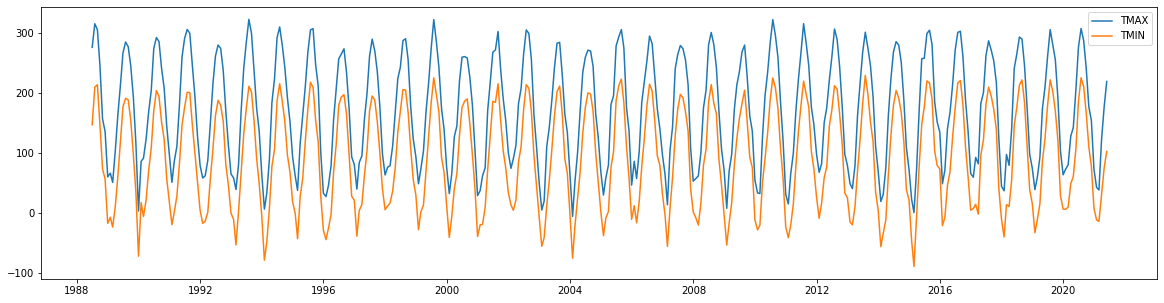

In [ ]:
data_by_month = data.resample('M').mean()

time = data_by_month.index.values
tmax = data_by_month['TMAX'].values
tmin = data_by_month['TMIN'].values

plt.figure(figsize=(20,5))
plt.plot(time, tmax, label='TMAX')
plt.plot(time, tmin, label='TMIN')
plt.legend()

In [ ]:
data_train = data[list(data)[:]].astype(float)
data_train

,TMAX,TMIN
MM/DD/YYYY,,
1988-06-27,283.0,144.0
1988-06-28,300.0,161.0
1988-06-29,267.0,156.0
1988-06-30,256.0,128.0
1988-07-01,217.0,117.0
...,...,...
2021-04-30,217.0,78.0
2021-05-01,183.0,56.0
2021-05-02,278.0,133.0


In [ ]:
data_scaled = MinMaxScaler().fit_transform(data_train)
data_scaled

array([[0.77586207, 0.69665272],
       [0.80842912, 0.73221757],
       [0.74521073, 0.72175732],
       ...,
       [0.76628352, 0.67364017],
       [0.59578544, 0.62761506],
       [0.67049808, 0.62761506]])

In [ ]:
x_train, y_train = [], []
n_future = 1
n_past = 14

for i in range(n_past, len(data_scaled) - n_future + 1):
  x_train.append(data_scaled[i - n_past : i, 0 : data_train.shape[1]])
  y_train.append(data_scaled[i + n_future - 1 : i + n_future, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(11986, 14, 2)
(11986, 1)


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(9588, 14, 2)
(2398, 14, 2)
(9588, 1)
(2398, 1)


In [ ]:
model = tf.keras.models.Sequential([
    LSTM(64, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(train_y.shape[1])
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 42,113
Trainable params: 42,113
Non-trainable params: 0
____________________________________________________

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.1 and logs.get('val_mae') < 0.1) and epoch >= 10:
      print('\nPada epoch>=10, MAE dan Val_MAE telah mencapai <10% !')
      self.model.stop_training = True

callback = myCallback()

In [ ]:
history = model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    callbacks=callback,
    epochs=20,
    verbose=1)

Epoch 1/20
300/300 [==============================] - 9s 19ms/step - loss: 0.0283 - mae: 0.1873 - val_loss: 0.0141 - val_mae: 0.1432
Epoch 2/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0139 - mae: 0.1406 - val_loss: 0.0127 - val_mae: 0.1353
Epoch 3/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0124 - mae: 0.1322 - val_loss: 0.0110 - val_mae: 0.1256
Epoch 4/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0107 - mae: 0.1221 - val_loss: 0.0092 - val_mae: 0.1143
Epoch 5/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0090 - mae: 0.1105 - val_loss: 0.0075 - val_mae: 0.1022
Epoch 6/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0074 - mae: 0.0999 - val_loss: 0.0061 - val_mae: 0.0906
Epoch 7/20
300/300 [==============================] - 5s 16ms/step - loss: 0.0061 - mae: 0.0897 - val_loss: 0.0053 - val_mae: 0.0830
Epoch 8/20
300/300 [==============================] - 5s 16ms/step - 

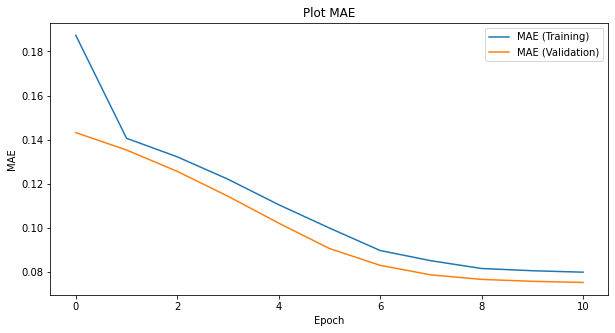

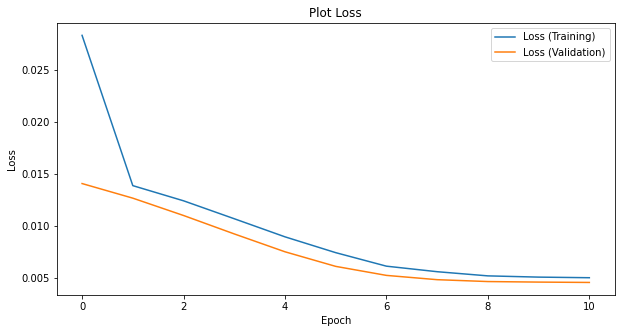

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['mae'], label='MAE (Training)')
plt.plot(history.epoch, history.history['val_mae'], label='MAE (Validation)')
plt.title('Plot MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.epoch, history.history['loss'], label='Loss (Training)')
plt.plot(history.epoch, history.history['val_loss'], label='Loss (Validation)')
plt.title('Plot Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()